In [1]:
%pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/tensorflow/examples.git to c:\users\asus\appdata\local\temp\pip-req-build-bd6n0ais
  Resolved https://github.com/tensorflow/examples.git to commit 39023864834a05965ed6e72c195140dc413f4b02
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1738929081.325461987918117995536210174468518373090689764098-py3-none-any.whl size=303879 sha256=8226cf89a1fd316217dd8a944f56b98d9634d044d679ebb2bbaa7c9b71fa0faf
  Stored in directory: C:\Users\ASUS\AppData\Local\Temp\pip-ephem-wheel-cache-nedtxh2a\wheels\ab\17\30\d16d07e2c95286770a9ddcd6f41629ea92b998858c5ee235aa
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\ASUS\AppData\Local\Temp\pip-req-build-bd6n0ais'


In [3]:
%pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:--
   - -------------------------------------- 0.3/5.3 MB ? eta -:--:

In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
ds, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ASUS\tensorflow_datasets\oxford_iiit_pet\incomplete.VPLZYW_4.0.0\oxford_iiit_pet-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ASUS\tensorflow_datasets\oxford_iiit_pet\incomplete.VPLZYW_4.0.0\oxford_iiit_pet-test.tfrec…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\ASUS\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


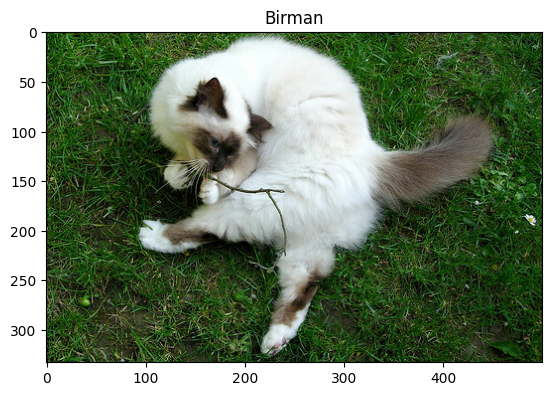

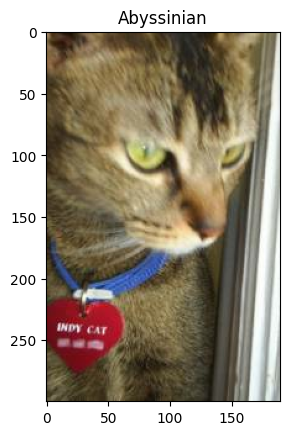

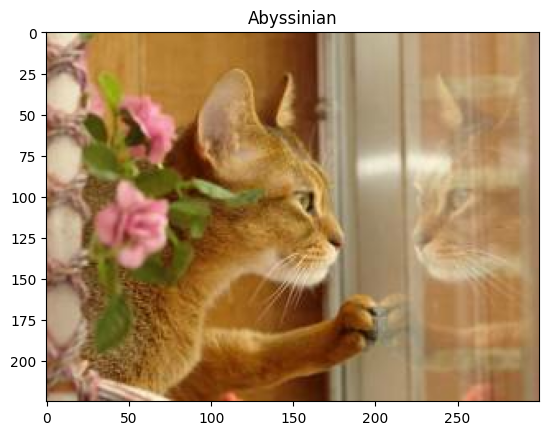

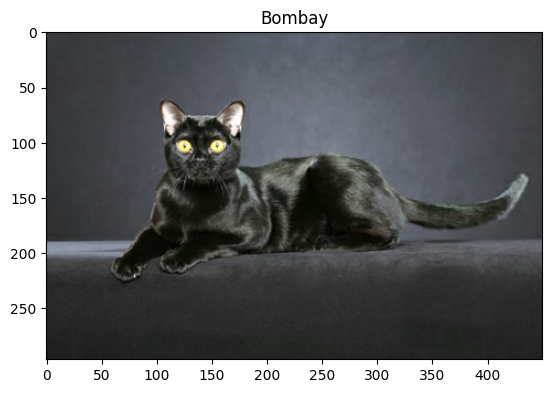

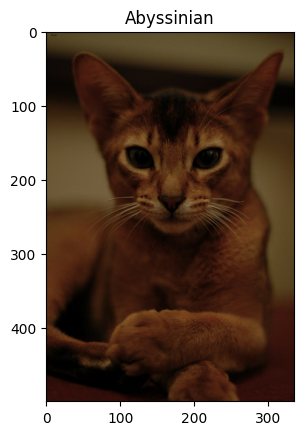

In [15]:
for i in range(5):
    random_index = np.random.randint(0, len(df))
    img = tf.io.read_file(df['Image_Path'][random_index])
    img = tf.image.decode_jpeg(img, channels=3)
    plt.imshow(img)
    plt.title(df['Label'][random_index])
    plt.show()

In [2]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\ASUS\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'l

In [5]:
print(ds)

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 #so the mask contain 3 dim diffcolors  --> zero base index
  return input_image, input_mask

def load_train_image(datapoint):
  # data augmentation
  input_image  = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  
  #data augmentation
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  # normalize the image and mask
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask

def load_test_image(datapoint):
  # data augmentation
  input_image  = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  
  # normalize the image and mask
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask




In [10]:
train_dataset = ds['train'].map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = ds['test'].map(load_test_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

#### Explainatory Data Analysis

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)
    plt.axis('off')
  plt.show()



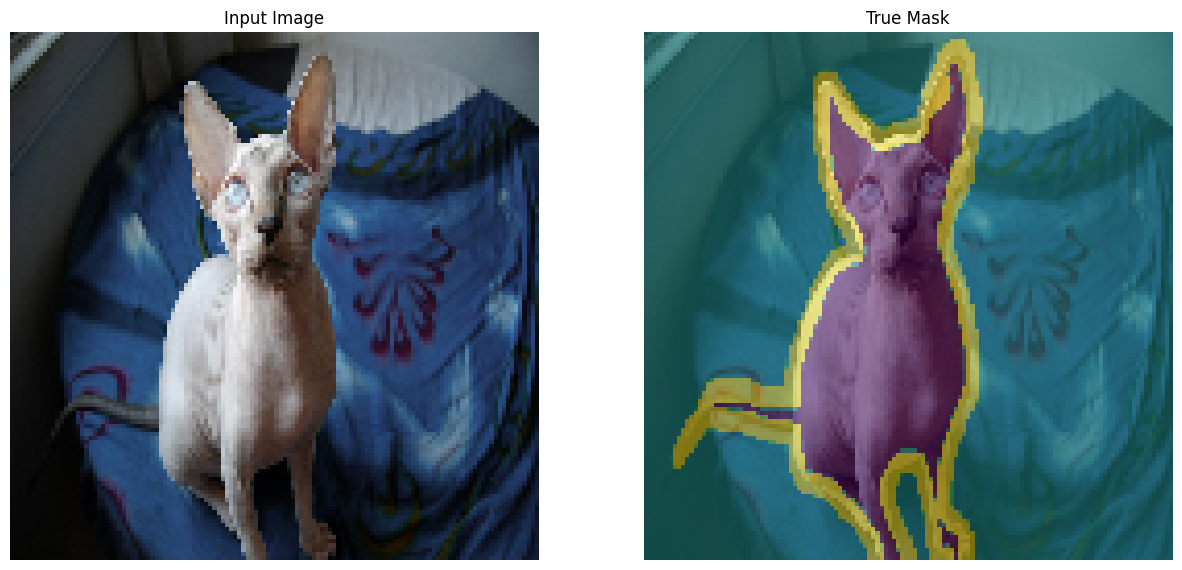

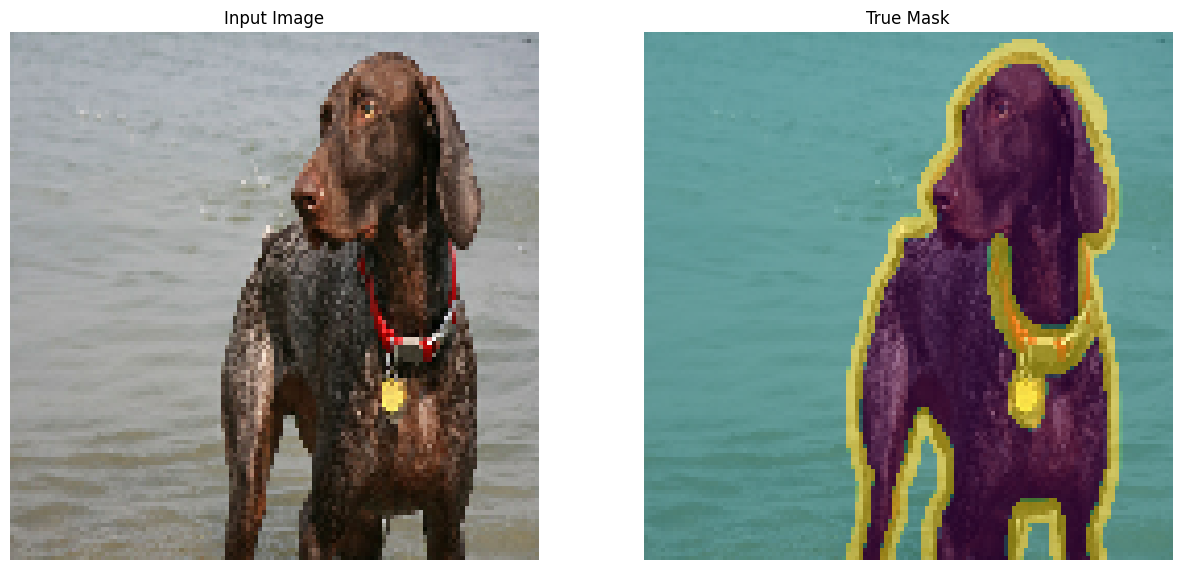

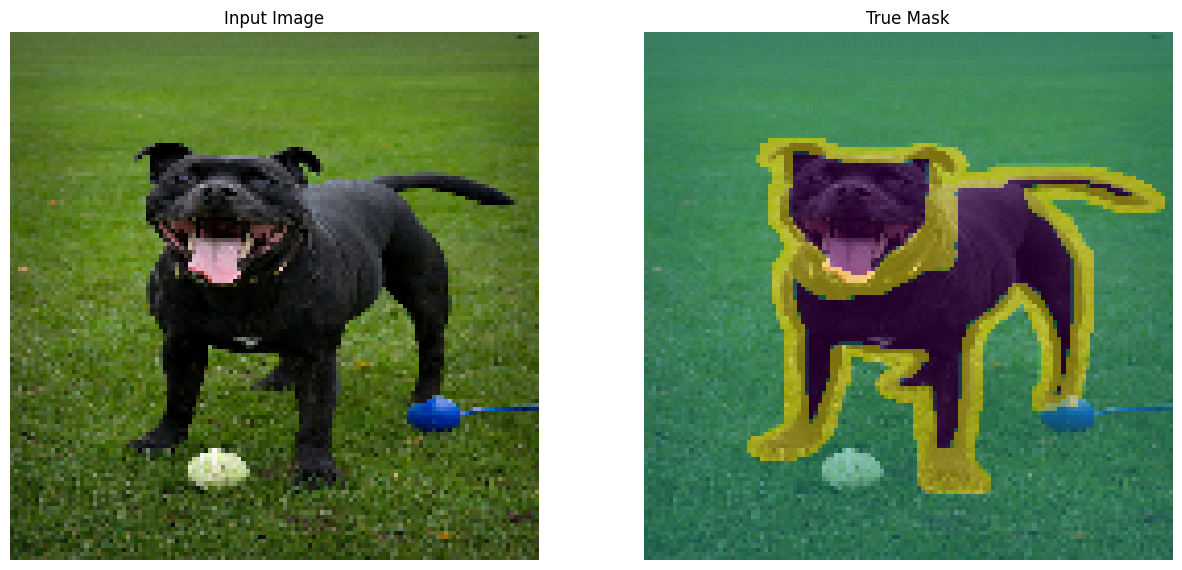

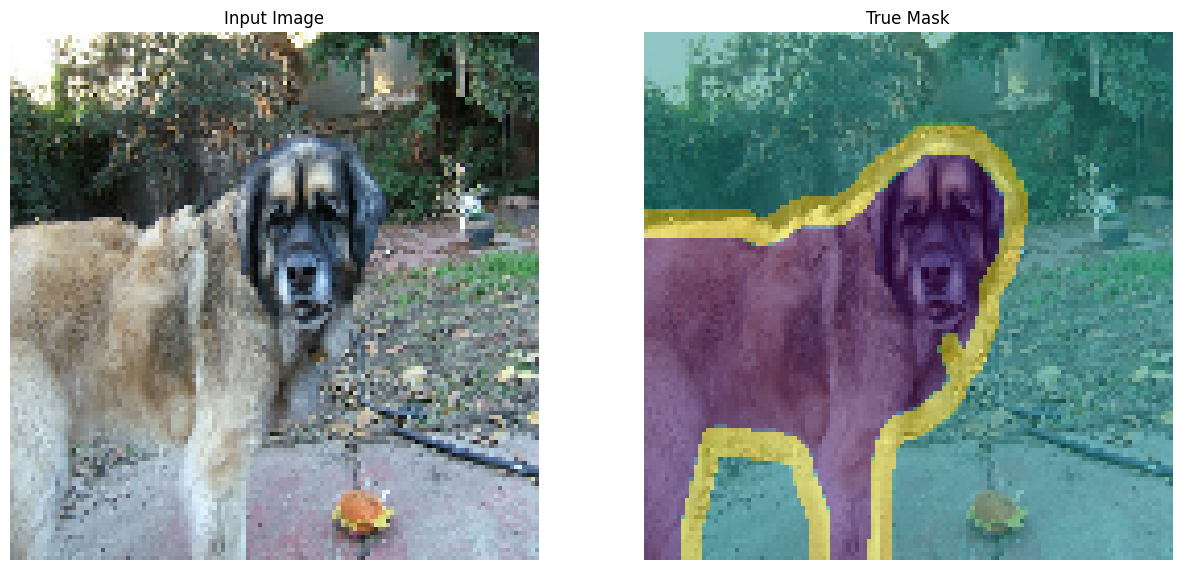

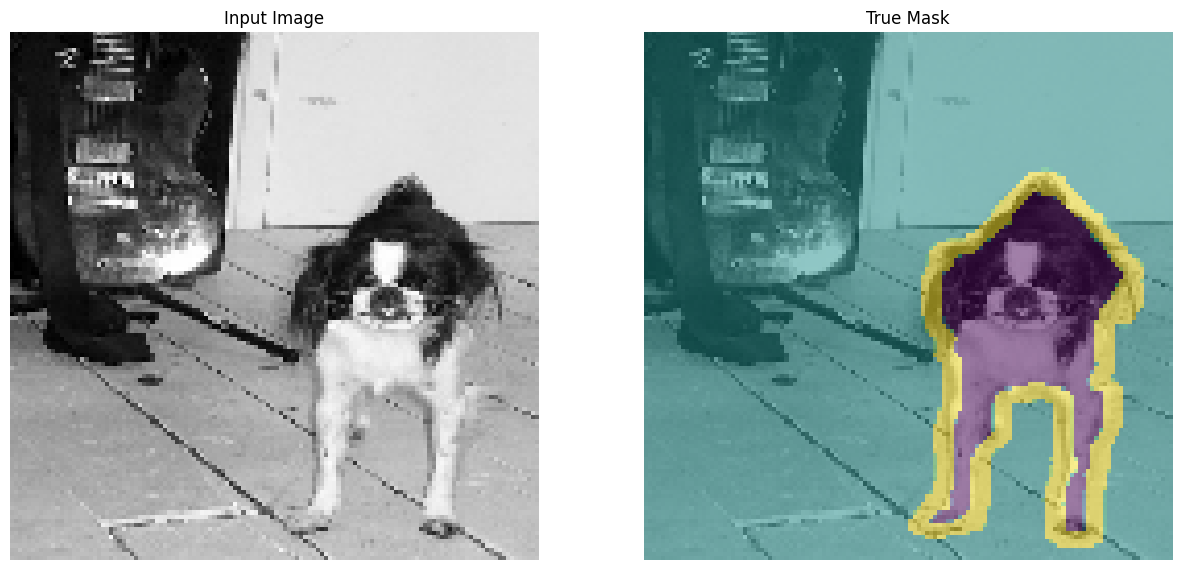

In [14]:
for images, masks in train_dataset.take(5):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

#### define unet model

In [37]:
def double_conv_block(x, n_filters):
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [38]:
def build_unet(input_shape = (128, 128, 3) ,output_channels = 3):
    inputs = tf.keras.layers.Input(input_shape)
    
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    
    #intermediate layer
    intermediate_layer = double_conv_block(p4, 1024)

    # upsample decoding
    u1 = upsample_block(intermediate_layer, f4, 512)
    u2 = upsample_block(u1, f3, 256)
    u3 = upsample_block(u2, f2, 128)
    u4 = upsample_block(u3, f1, 64)

    outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation='softmax')(u4)
    model = tf.keras.models.Model(inputs, outputs , name = 'U-Net')
    return model


In [39]:
model = build_unet()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
%pip install pydot

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.



In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


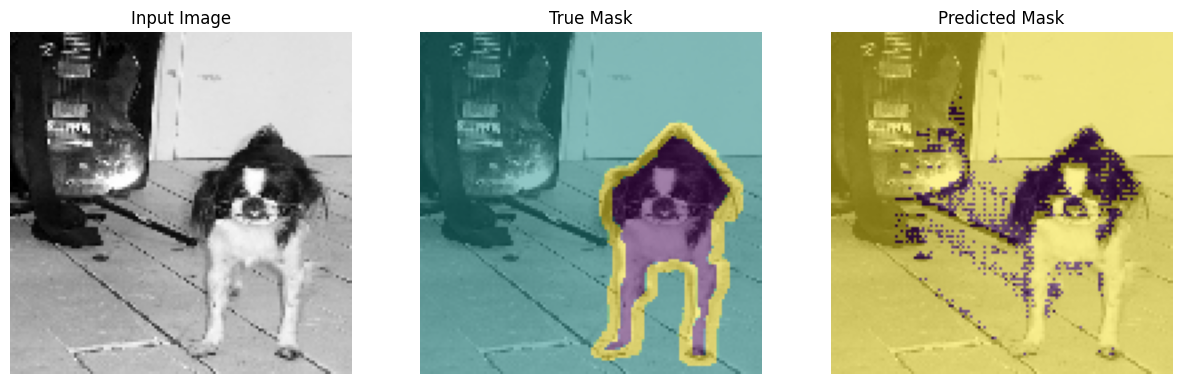


Sample Prediction after epoch 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 1305s 23s/step - accuracy: 0.5565 - loss: 0.9474 - val_accuracy: 0.6263 - val_loss: 0.7825
Epoch 2/3
12/57 ━━━━━━━━━━━━━━━━━━━━ 18:07 24s/step - accuracy: 0.5995 - loss: 0.8679

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions(test_dataset)

In [ ]:
show_predictions(test_dataset, 3)